In [89]:
!pip install gymnasium

In [90]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [91]:
#!pip install --upgrade ptan torch
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

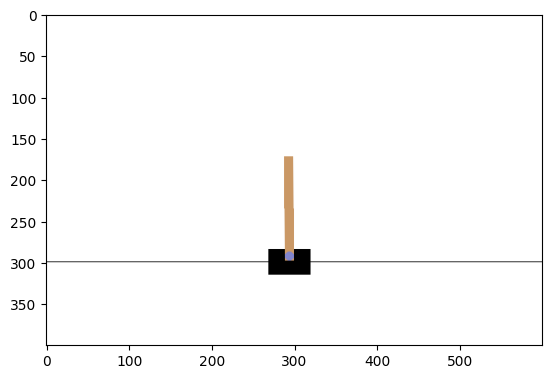

In [92]:
env=gym.make('CartPole-v1',render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [93]:
n_s=4
n_a=2
n_epi=1000
disc=.99
n_t=200

In [94]:
def get_bat(tau):
  s_bat=torch.Tensor([s for (s,a,r,s1,d) in tau])
  a_bat=torch.Tensor([a for (s,a,r,s1,d) in tau]).long()
  r_bat=torch.Tensor([r for (s,a,r,s1,d) in tau])
  s1_bat=torch.Tensor([s1 for (s,a,r,s1,d) in tau])
  done_bat=torch.Tensor([d for (s,a,r,s1,d) in tau])
  return s_bat,a_bat,r_bat,s1_bat,done_bat

In [95]:
class ACNetwork(nn.Module):
  def __init__(self,n_s,n_a):
    super(ACNetwork,self).__init__()
    self.h1=nn.Linear(n_s,64)
    self.h2=nn.Linear(64,64)
    self.out_pi=nn.Linear(64,n_a)
    self.out_v=nn.Linear(64,1)
  def forward(self,s):
    x=torch.relu(self.h1(s))
    x=torch.relu(self.h2(x))
    pi=torch.softmax(self.out_pi(x),dim=-1)
    v=self.out_v(x)
    return pi,v

In [96]:
AC_net=ACNetwork(n_s,n_a)

In [97]:
losses=[]

In [98]:
def loss_fn(pi_bat,y,y_hat):
  err=y-y_hat
  loss_act=-1*torch.sum(torch.log(pi_bat)*err.detach())
  loss_cri=torch.mean(torch.square(err))
  w_act=(loss_cri/(loss_act+loss_cri)).detach()
  w_cri=1-w_act
  return w_act*loss_act+w_cri*loss_cri
optimizer=torch.optim.Adam(AC_net.parameters(),lr=1e-3)

In [99]:
env=gym.make("CartPole-v1",render_mode=None)
scores=[]

In [100]:
for i in range(n_epi):
  tau=[]
  s,_=env.reset()
  done=False
  while not done and len(tau)<n_t:
    Pi,_=AC_net(torch.Tensor(s))
    a=np.random.choice(range(n_a),p=Pi.detach().numpy())
    s1,r,done,_,_=env.step(a)
    tau.append((s,a,r,s1,done))
    s=s1
  s_bat,a_bat,r_bat,s1_bat,done_bat=get_bat(tau)
  Pi_bat,V_bat=AC_net(s_bat)
  pi_bat=Pi_bat.gather(dim=1,index=a_bat.view(-1,1)).squeeze()
  y_hat=V_bat.squeeze()
  _,V1_bat=AC_net(s1_bat)
  v1_bat=V1_bat.squeeze()
  y=r_bat+(1-done_bat)*(disc*v1_bat)
  loss=loss_fn(pi_bat,y,y_hat)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  scores.append(len(tau))
  print(i,loss.item(),scores[i])
  clear_output(wait=True)

999 1.6634191274642944 200


Text(0, 0.5, 'Loss')

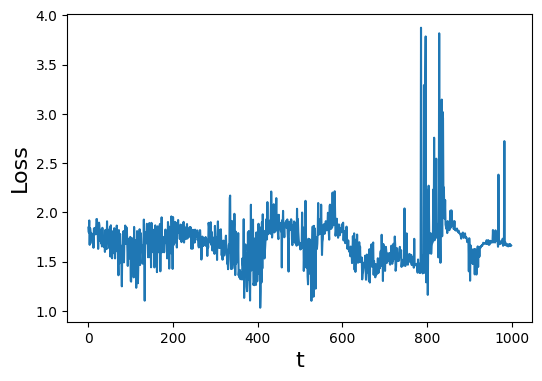

In [101]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

Text(0, 0.5, 'Score')

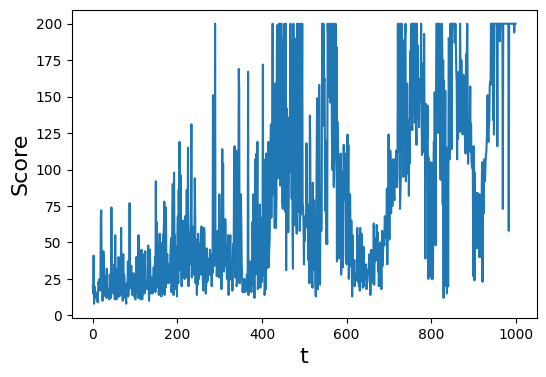

In [102]:
plt.figure(figsize=(6,4))
plt.plot(scores)
plt.xlabel("t",fontsize=16)
plt.ylabel("Score",fontsize=16)

In [103]:
def test_agent(model,n_t=200,mode='human',display=True):
  env=gym.make('CartPole-v1',render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    Pi,_=model(torch.Tensor(s))
    a=np.random.choice(range(n_a),p=Pi.data.numpy())
    s1,r,done,_,_=env.step(a)
    if display:
      print('t=',t,'\n','s=',s,'\n','a=',a,'\n','r=',r,'\n','s\'=',s1,'\n','done=',done)
      clear_output(wait=True)
    s=s1
    if done:
      if display:
        print('You Score:%s'%(t+1))
      break
  if not done:
    if display:
      print('Your Score:%s'%(t+1))
  return t+1

In [104]:
test_agent(AC_net)

Your Score:200


200

192.3


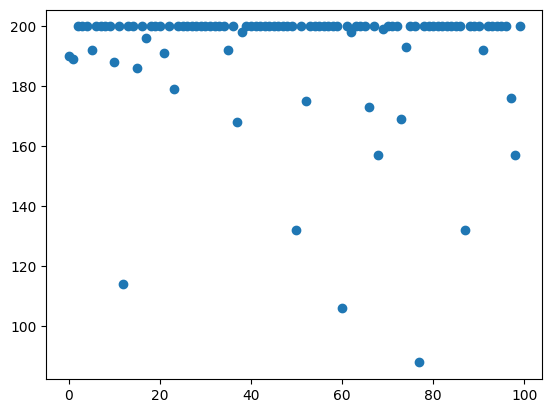

In [105]:
n_game=100
scores=[]
s,_=env.reset()
for i in range(n_game):
  score=test_agent(AC_net,mode=None,display=False)
  scores.append(score)
print(np.mean(scores))
plt.scatter(np.arange(len(scores)),scores)